<a href="https://colab.research.google.com/github/RNy7846/Doencas_Foliares/blob/main/DenseNet_Folhas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importando Bibliotecas

In [ ]:
import os
import cv2
import pathlib
import visualkeras

import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.12.0


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/Folhas/taiwan/data augmentation/Train'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/Folhas/taiwan/data augmentation/Test'

TRAIN_BACTERIA = os.listdir(TRAIN_PATH + '/Bacterial spot')
TRAIN_BLACK = os.listdir(TRAIN_PATH + '/Black mold')
TRAIN_GRAY = os.listdir(TRAIN_PATH + '/Gray spot')
TRAIN_HEALTH = os.listdir(TRAIN_PATH + '/health')
TRAIN_LATE = os.listdir(TRAIN_PATH + '/Late blight')
TRAIN_POWDERY = os.listdir(TRAIN_PATH + '/powdery mildew')


TEST_BACTERIA = os.listdir(TEST_PATH + '/Bacterial spot')
TEST_BLACK = os.listdir(TEST_PATH + '/Black mold')
TEST_GRAY = os.listdir(TEST_PATH + '/Gray spot')
TEST_HEALTH = os.listdir(TEST_PATH + '/health')
TEST_LATE = os.listdir(TEST_PATH + '/Late blight')
TEST_POWDERY = os.listdir(TEST_PATH + '/powdery mildew')

IMG_SIZE = 224
TARGET_SIZE = (224, 224)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Bacterial spot','Black mold','Gray spot', 'Health', 'Late blight', 'Powdery mildew']

# Verificando a Base de Dados

Tamanhos da base de dados e % de split de dados

In [ ]:
num_train_bacterial = len(TRAIN_BACTERIA)
num_train_black = len(TRAIN_BLACK)
num_train_gray = len(TRAIN_GRAY)
num_train_health = len(TRAIN_HEALTH)
num_train_late = len(TRAIN_LATE)
num_train_powdery = len(TRAIN_POWDERY)

num_train = num_train_bacterial + num_train_black + num_train_gray + num_train_health + num_train_late + num_train_powdery


num_test_bacterial = len(TEST_BACTERIA)
num_test_black = len(TEST_BLACK)
num_test_gray = len(TEST_GRAY)
num_test_health = len(TEST_HEALTH)
num_test_late = len(TEST_LATE)
num_test_powdery = len(TEST_POWDERY)

num_test = num_test_bacterial + num_test_black + num_test_gray + num_test_health + num_test_late + num_test_powdery

num_all = num_train + num_test

print('Total de imagens no set de treino: ', num_train,'--->', round(num_train/num_all,3)*100, '%')
print('=================================================')


print('Total de imagens no set de teste: ', num_test, '--->', round(num_test/num_all,3)*100, '%')
print('=================================================')
print('\nTotal de Imagens no Dataset: ', num_all)

Total de imagens no set de treino:  3978 ---> 79.9 %
Total de imagens no set de teste:  998 ---> 20.1 %

Total de Imagens no Dataset:  4976


In [ ]:
train_list = [x for x in TRAIN_BACTERIA]
train_list.extend([x for x in TRAIN_BLACK])
train_list.extend([x for x in TRAIN_GRAY])
train_list.extend([x for x in TRAIN_HEALTH])
train_list.extend([x for x in TRAIN_LATE])
train_list.extend([x for x in TRAIN_POWDERY])


df_train = pd.DataFrame(np.concatenate([['Bacterial spot']*len(TRAIN_BACTERIA) , ['Black mold']*len(TRAIN_BLACK), ['Gray spot']*len(TRAIN_GRAY), ['Health']*len(TRAIN_HEALTH), ['Late blight']*len(TRAIN_LATE), ['Powdery mildew']*len(TRAIN_POWDERY)]), columns = ['class'])
df_train['image'] = [x for x in train_list]


test_list = [x for x in TEST_BACTERIA]
test_list.extend([x for x in TEST_BLACK])
test_list.extend([x for x in TEST_GRAY])
test_list.extend([x for x in TEST_HEALTH])
test_list.extend([x for x in TEST_LATE])
test_list.extend([x for x in TEST_POWDERY])



df_test = pd.DataFrame(np.concatenate([['Bacterial spot']*len(TEST_BACTERIA) , ['Black mold']*len(TEST_BLACK), ['Gray spot']*len(TEST_GRAY), ['Health']*len(TEST_HEALTH), ['Late blight']*len(TEST_LATE), ['Powdery mildew']*len(TEST_POWDERY)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

**Verificando Base de Treino**

Quantidades e % de amostras por classe

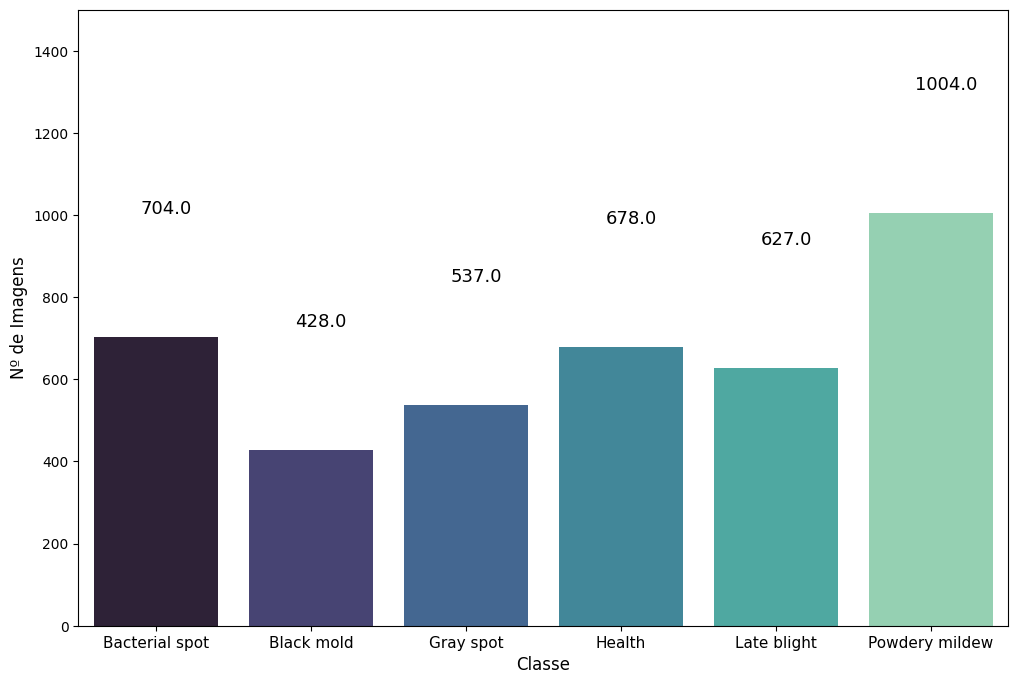

In [ ]:
plt.figure(figsize=(12,8))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Classe", fontsize= 12)
plt.ylabel("Nº de Imagens", fontsize= 12)
plt.ylim(0,1500)
plt.xticks([0,1,2,3,4,5], ['Bacterial spot','Black mold','Gray spot', 'Health', 'Late blight', 'Powdery mildew'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

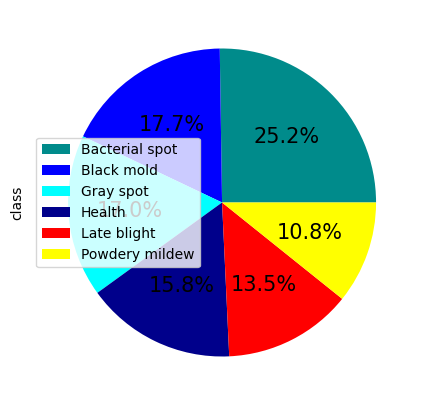

In [ ]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['','', '','','',''], autopct='%1.1f%%', colors = ['darkcyan','blue', 'cyan', 'darkblue', 'red', 'yellow'], explode = [0,0,0,0,0,0], textprops = {"fontsize":15})

plt.legend(labels=['Bacterial spot','Black mold','Gray spot', 'Health', 'Late blight', 'Powdery mildew'])
plt.show()

**Verificando Base de Teste**

Quantidades e % de amostras por classe

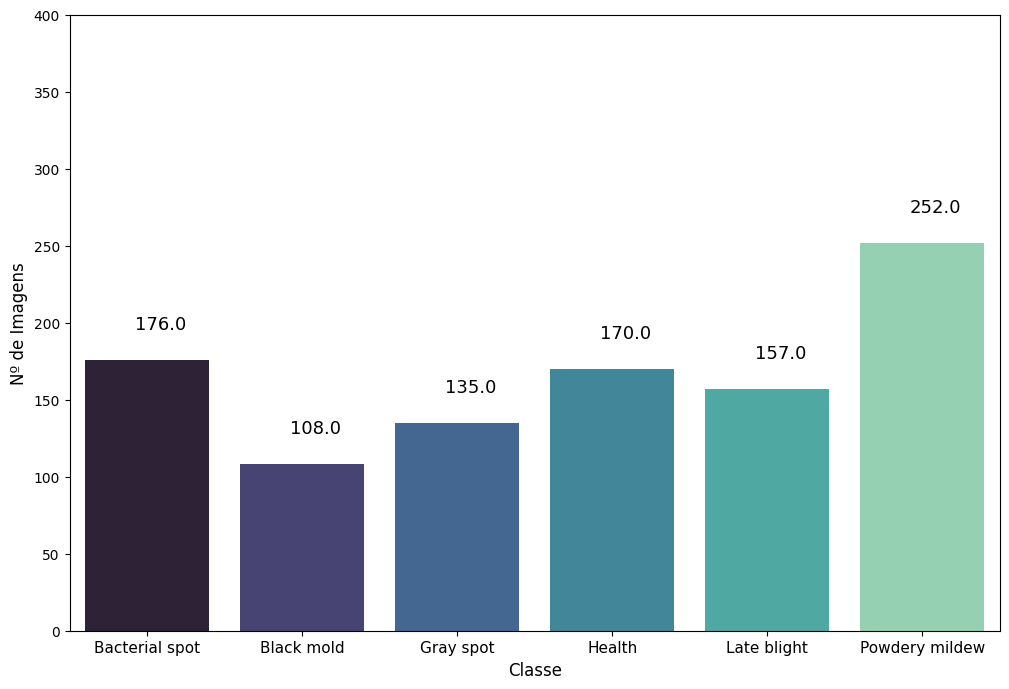

In [ ]:
plt.figure(figsize=(12,8))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Classe", fontsize= 12)
plt.ylabel("Nº de Imagens", fontsize= 12)
plt.ylim(0,400)
plt.xticks([0,1,2,3,4,5], ['Bacterial spot','Black mold','Gray spot', 'Health', 'Late blight', 'Powdery mildew'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

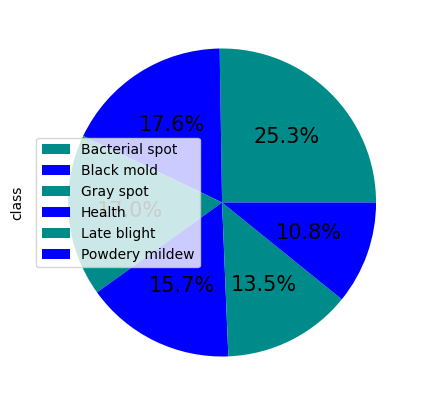

In [ ]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['','','','','',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0,0,0,0,0], textprops = {"fontsize":15})

plt.legend(labels=['Bacterial spot','Black mold','Gray spot', 'Health', 'Late blight', 'Powdery mildew'])
plt.show()

In [ ]:
def sampleImage(sampe_image_path):
  img = load_img(TRAIN_PATH + sampe_image_path)
  x = img_to_array(img)
  print(x.shape)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

(227, 227, 3)


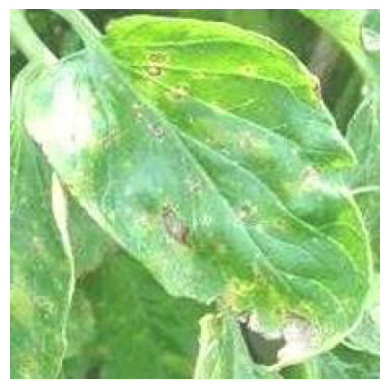

In [ ]:
sample_image_path = "/Bacterial spot/Bs106_hight.jpg"
sampleImage(sample_image_path)

# Data Augmentation

A ideia por trás do data augmentation é a introdução de variações no conjunto de dados de treinamento pode melhorar o desempenho do modelo, tornando-o mais robusto a variações nos dados de entrada. Essa técnica é útil quando o conjunto de dados de treinamento é pequeno, já que aumenta artificialmente o tamanho do conjunto de dados , reduzindo o risco de overfitting.

In [ ]:
# Data-Augmentation
ZOOM = [.99, 1.1] #Nível de zoom aplicado na imagem (Amplia ou distancia a imagem)
BRIGHT_RANGE = [0.8, 1.2] # alteração de brilho na imagem (Deixa a imagem mais clara ou mais escura)
HORZ_FLIP = True # Flip Horizontal na imagem (Ajuda a identificar pneumonia nos dois pulmões)
FILL_MODE = "constant" #Tipo de preenchimento da imagem (Bordas Pretas)
DATA_FORMAT = "channels_last"

train_datagen = IDG(validation_split=0.2,
                    rescale=1./255) 
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Validação\Teste não deve ser aumentado.
test_datagen = IDG(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 3186 images belonging to 6 classes.
Found 792 images belonging to 6 classes.
Found 998 images belonging to 6 classes.


# Visualização do Processo de Data Augmentation

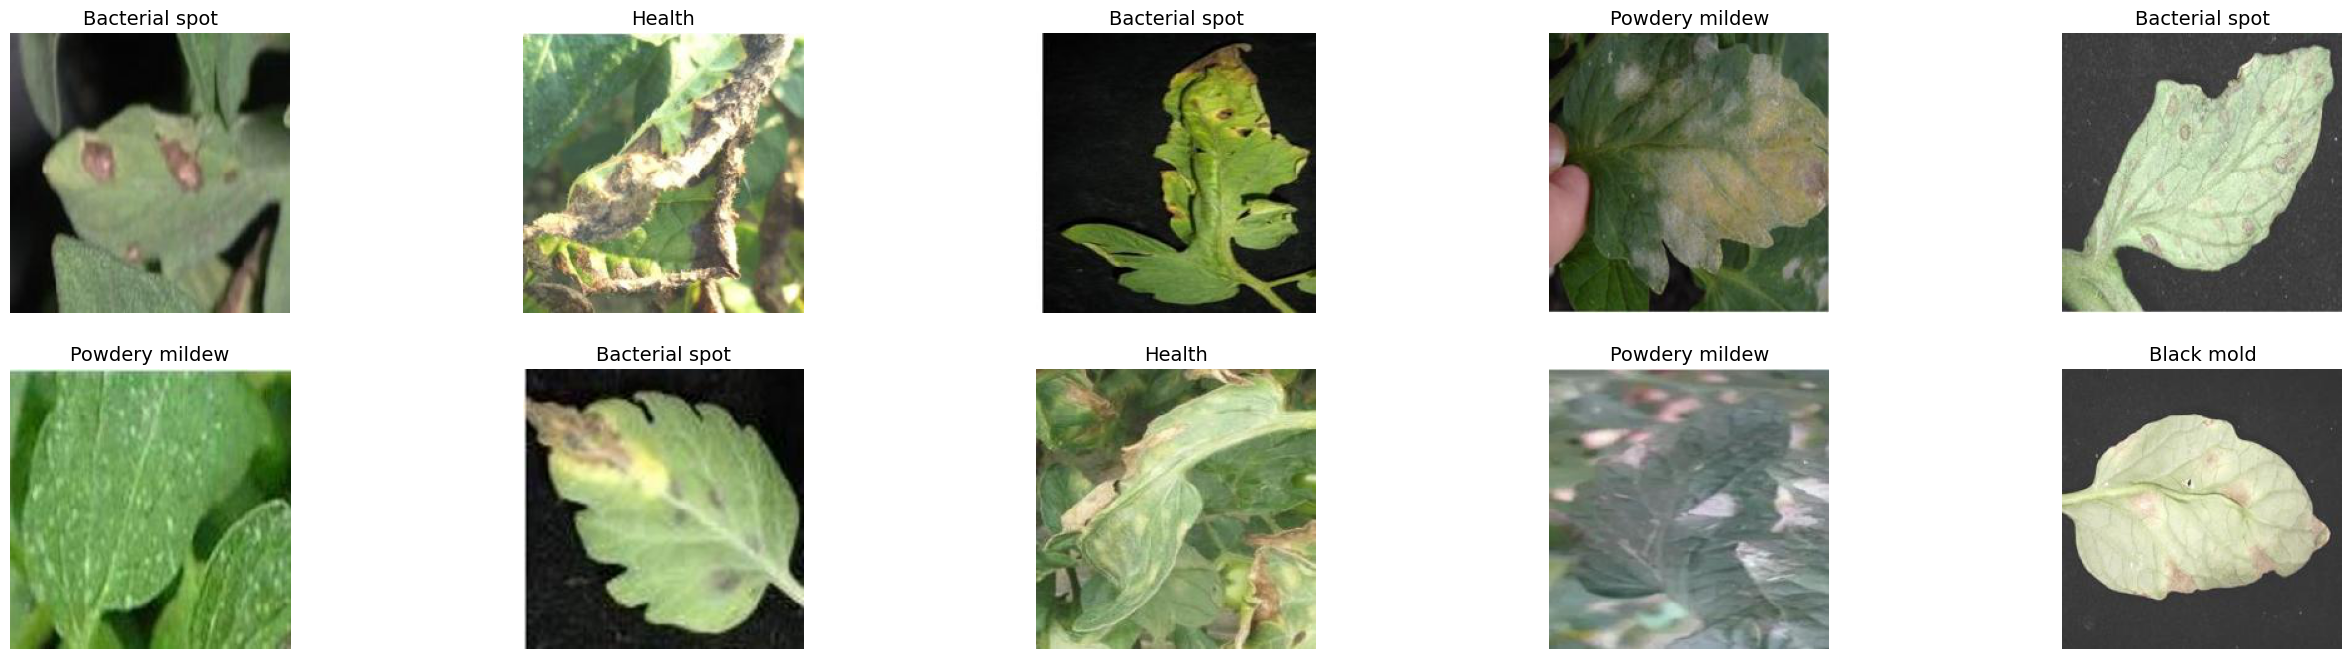

In [ ]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

# Importanto Modelo Pré-Treinado

O parâmetro *weights* define que a utilização de pesos pré-treinados na base de dados ImageNet. O parâmetro *include_top* define a inclusão camadas densas finais da rede, que foram treinadas na base de dados ImageNet para realizar a classificação de imagens em mais de 1.000 categorias.

In [ ]:
DenseT = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
from PIL import ImageFont

font = ImageFont.truetype("/content/drive/MyDrive/Colab Notebooks/DATASET/arial.ttf", 100)
visualkeras.layered_view(DenseT, legend=True, font=font)

# Adicionando Camadas ao Modelo e Travando o Aprendizado das Camadas

O transfer learning é uma técnica que consiste em utilizar conhecimentos adquiridos em um modelo treinado em uma tarefa para melhorar o desempenho de um modelo em outra tarefa relacionada. Permite reutilizar os pesos e camadas de um modelo pré-treinado em uma tarefa relacionada, e adaptar esse modelo para a nova tarefa. 

In [ ]:
for layer in DenseT.layers:
    layer.trainable=True

In [ ]:
Dense_model = DenseT.output
Dense_model = tf.keras.layers.Dropout(0.35)(Dense_model)
Dense_model = tf.keras.layers.GlobalAveragePooling2D()(Dense_model)
Dense_model = tf.keras.layers.Dropout(0.25)(Dense_model)
Dense_model = tf.keras.layers.Dense(6, kernel_initializer=GlorotNormal(),
                          activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                          bias_regularizer= tf.keras.regularizers.L2(0.0001))(Dense_model)

Dense_model = tf.keras.models.Model(inputs=DenseT.input, outputs = Dense_model)

visualkeras.layered_view(Dense_model, legend=True, font=font)

# Definição de Métricas e Callbacks

**Calculo F1-Score**

In [ ]:
METRICS = [
            tf.keras.metrics.BinaryAccuracy(name='acuracia'),
            tf.keras.metrics.Precision(name='precisão'),
            tf.keras.metrics.Recall(name='recall'),  
            tf.keras.metrics.AUC(name='auc'),
           ]

**Definição das Callbacks**

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early = EarlyStopping(monitor='auc', patience=5)

A adaptação da taxa de aprendizado permite que o algoritmo de aprendizado de máquina ajuste a taxa de aprendizado em tempo real, permitindo que ele se adapte a diferentes problemas de aprendizado e minimize a perda com mais eficiência.

O early stopping ajuda a garantir que o modelo tenha um bom desempenho não apenas nos dados de treinamento, mas também em novos dados. 

**Compilação do Modelo**

In [ ]:
Dense_model.compile(optimizer='rmsprop',
                    loss=tf.losses.CategoricalCrossentropy(),
                    metrics=METRICS)

O RMSprop ajusta a taxa de aprendizado para cada peso de acordo com a magnitude média do gradiente daquele peso ao longo do tempo.

A Categorical Cross Entropy é uma função loss contínua e diferenciável, o que a torna adequada para uso em algoritmos de otimização baseados em gradiente descendente, como o RMSprop. Ela é usada para minimizar o erro de classificação do modelo durante o treinamento, ajustando os pesos da rede neural para melhorar a precisão da classificação.

# Treinamento da Rede

In [ ]:
history = Dense_model.fit(train_generator,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler, early],
                    verbose=1)

print('\n*** Acabou o treinamento ***')

Epoch 1/100
100/100 [==============================] - 178s 778ms/step - loss: 1.2837 - acuracia: 0.8650 - precisão: 0.6738 - recall: 0.3682 - auc: 0.8423 - val_loss: 120.5070 - val_acuracia: 0.7235 - val_precisão: 0.1705 - val_recall: 0.1705 - val_auc: 0.5023 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 74s 744ms/step - loss: 0.5525 - acuracia: 0.9342 - precisão: 0.8468 - recall: 0.7392 - auc: 0.9684 - val_loss: 2.1985 - val_acuracia: 0.8550 - val_precisão: 0.5720 - val_recall: 0.5164 - val_auc: 0.8270 - lr: 3.9811e-04
Epoch 3/100
100/100 [==============================] - 73s 730ms/step - loss: 0.1803 - acuracia: 0.9797 - precisão: 0.9498 - recall: 0.9269 - auc: 0.9962 - val_loss: 0.7500 - val_acuracia: 0.9308 - val_precisão: 0.8238 - val_recall: 0.7437 - val_auc: 0.9475 - lr: 1.5849e-04
Epoch 4/100
100/100 [==============================] - 73s 730ms/step - loss: 0.0681 - acuracia: 0.9923 - precisão: 0.9789 - recall: 0.9746 - auc: 0.9991 - val_loss: 0.8571 - v

Salvando o modelo treinado

In [ ]:
Dense_model.save('/content/drive/MyDrive/Colab Notebooks/Folhas/Dense_model.h5')

# Visualização das Métricas de Treino

Construir um gráfico com o desenvolvimento das métricas durante o processo de treinamento e validação da rede.

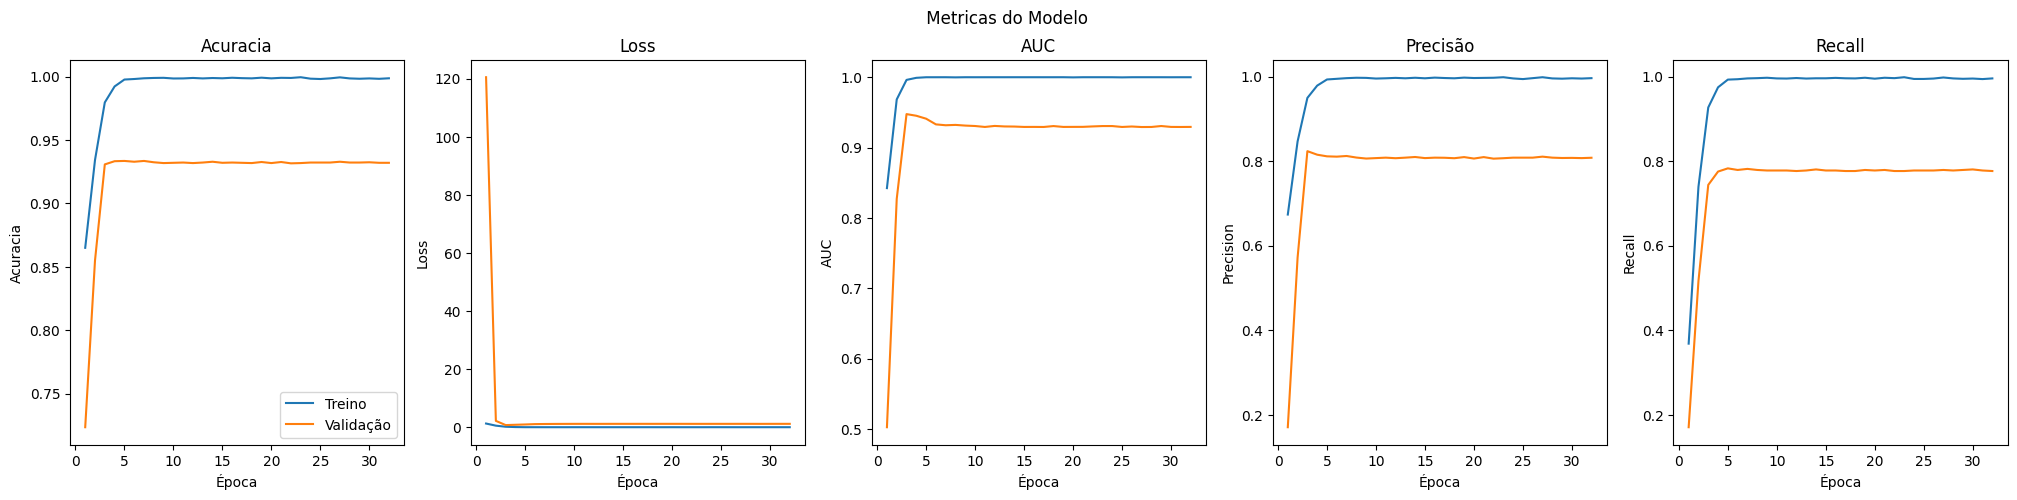

In [ ]:
#def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision, recall, val_recall):
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (25,5))
    fig.suptitle(" Metricas do Modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Validação'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Validação'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Validação'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Época')
    ax4.set_ylabel('Precision')
    ax1.legend(['Treino', 'Validação'])

    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('Recall')
    ax5.set_xlabel('Época')
    ax5.set_ylabel('Recall')
    ax1.legend(['Treino', 'Validação'])
    '''
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score')
    ax5.set_xlabel('Época')
    ax5.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Validação'])
'''

    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['recall'],history.history['val_recall'],
               #history.history['f1_score'],history.history['val_f1_score']
              )

# Visualização das Métricas de Teste

In [ ]:
test_scores = Dense_model.evaluate(test_generator)

print("Acuracia = ", test_scores[1])
print("Precisão = ", test_scores[2])
print("Recall = ", test_scores[3])
print("AUC = ", test_scores[4])
#print("F1_score = ", test_scores[5])

32/32 [==============================] - 6s 184ms/step - loss: 0.3064 - acuracia: 0.9825 - precisão: 0.9533 - recall: 0.9409 - auc: 0.9872
Acuracia =  0.9824649095535278
Precisão =  0.9532994627952576
Recall =  0.9408817887306213
AUC =  0.9871941804885864


A Loss indica o quão bem a rede neural convolucional está aprendendo durante o treinamento. Quanto menor a loss, melhor é o desempenho da rede. O valor de 0,1837 sugere que a rede está tendo um bom desempenho em minimizar a função de perda durante o treinamento.

A acurácia de 0,939 indica que a rede está acertando a classificação em 93,9% das imagens de Raio-x presentes na base de dados.

A precisão é a proporção de verdadeiros positivos entre todos os exemplos classificados como positivos, enquanto o recall é a proporção de verdadeiros positivos entre todos os exemplos positivos. Uma precisão e recall de 0,939 significam que a rede está acertando tanto nas previsões positivas quanto nas negativas. Esses valores são importantes porque indicam que a rede está sendo capaz de identificar corretamente tanto os casos de pneumonia quanto os casos saudáveis.

A área sob a curva ROC (AUC) é uma métrica que avalia a habilidade da rede em distinguir entre casos positivos e negativos, independentemente do ponto de corte escolhido para fazer a classificação. Nesse caso, a AUC de 0,979 indica que a rede é capaz de distinguir com precisão entre os casos de pneumonia e os casos saudáveis.

O F1-score é uma medida que combina tanto a precisão quanto o recall em uma única métrica. Um valor de F1-score de 0,9406 indica uma boa harmonia entre a precisão e o recall, o que é importante para a avaliação do desempenho da rede.



A rede neural convolucional utilizada para a tarefa de classificação de pneumonia em imagens de Raio-x obteve um desempenho muito bom, obtendo uma alta taxa de acurácia e precisão tanto nas previsões positivas quanto nas negativas, e uma capacidade de distinguir entre casos positivos e negativos muito boa.


# Visualização da Classificação

1/1 [==============================] - 0s 75ms/step


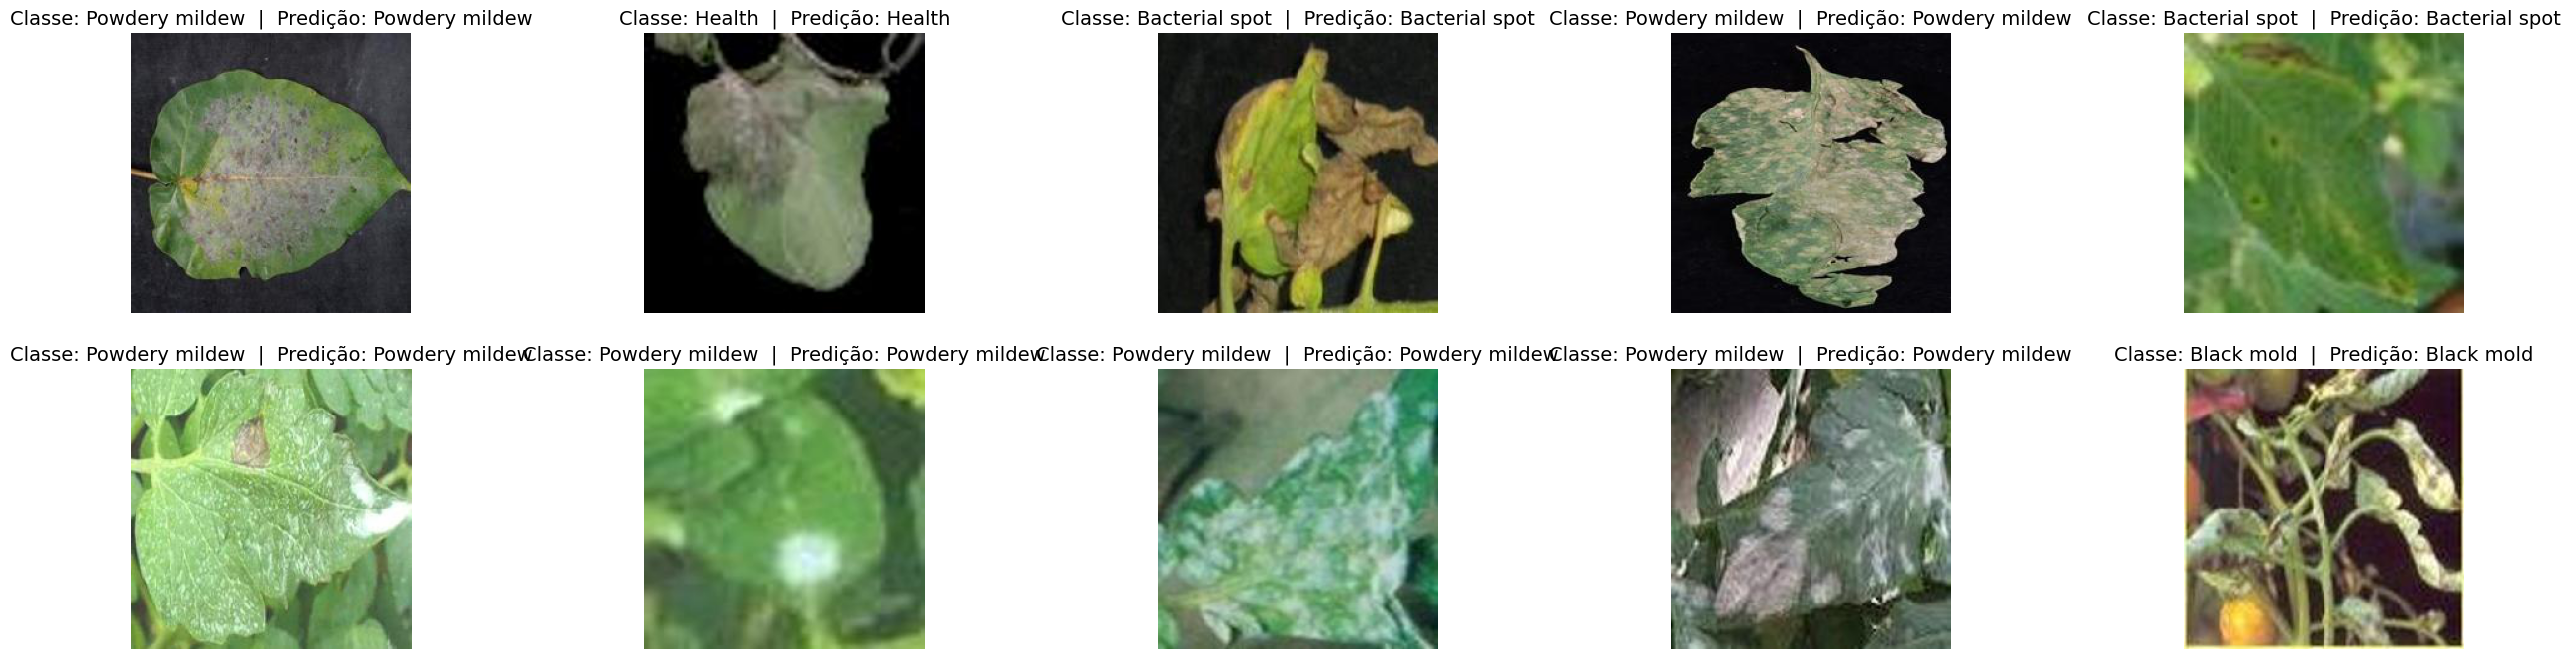

In [ ]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'Classe: {CLASSES[lab]}  |  Predição: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(Dense_model, 10, image_test, label_test)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Folhas/Dense_model.h5')
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
def getHeatMap(image):
  single_image = cv2.imread(image)
  single_image = cv2.resize(single_image, (224, 224))
  single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)
  img = single_image/255
  img = np.asarray(img)
  img = img.reshape(1, 224, 224, 3)
  y_pred = model.predict(img)[0]
  y_pred = np.argmax(y_pred)
  classes = list({'Bacterial spot':0,'Black mold':1,'Gray spot':2, 'Health':3, 'Late blight':4, 'Powdery mildew':5})
  class_prediction = classes[y_pred]
  weights = model.layers[-1].get_weights()[0]
  weights = np.asarray(weights)
  weights = weights.reshape(weights.shape[1], weights.shape[0])
  weights_for_predicted_class_for_this_image = weights[y_pred]
  new_model = tf.keras.models.Model(
    model.input, 
    model.get_layer('conv5_block32_concat').output
    )
  output_con_layer = new_model.predict(img)[0]
  resize_image = sc.ndimage.zoom(output_con_layer, (int(224/output_con_layer.shape[0]), 
                                                  int(224/output_con_layer.shape[1]), 1))
  final_image = np.dot(
      resize_image.reshape(resize_image.shape[0]*resize_image.shape[1], resize_image.shape[2]),
      weights_for_predicted_class_for_this_image
  ).reshape(resize_image.shape[0], resize_image.shape[1])
  img_ = img.reshape(224, 224, 3)
  final_image = final_image/255
  return [img_, final_image, class_prediction]

In [ ]:
dataset_folder='/content/drive/MyDrive/Colab Notebooks/Folhas/taiwan/data augmentation/'
datasetObject = pathlib.Path(os.path.join(dataset_folder))
images = list(datasetObject.glob("*/*/*.*"))
arr = []
for i in images[:8]:
  arr.append(getHeatMap(os.path.join(i)))

1/1 [==============================] - 5s 5s/step


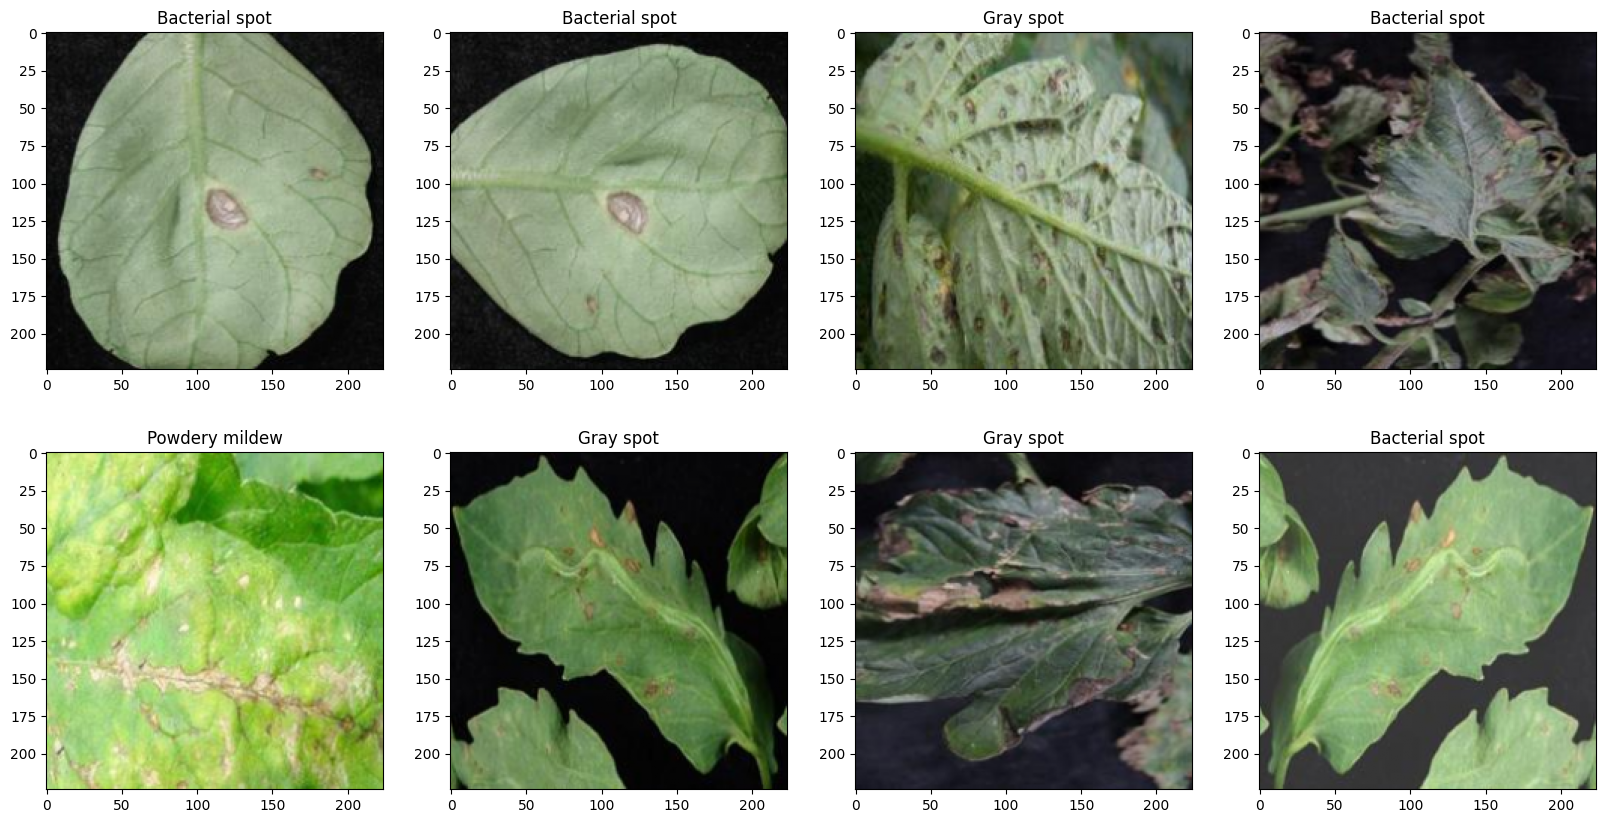

In [ ]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.title(i[2])
plt.show()  

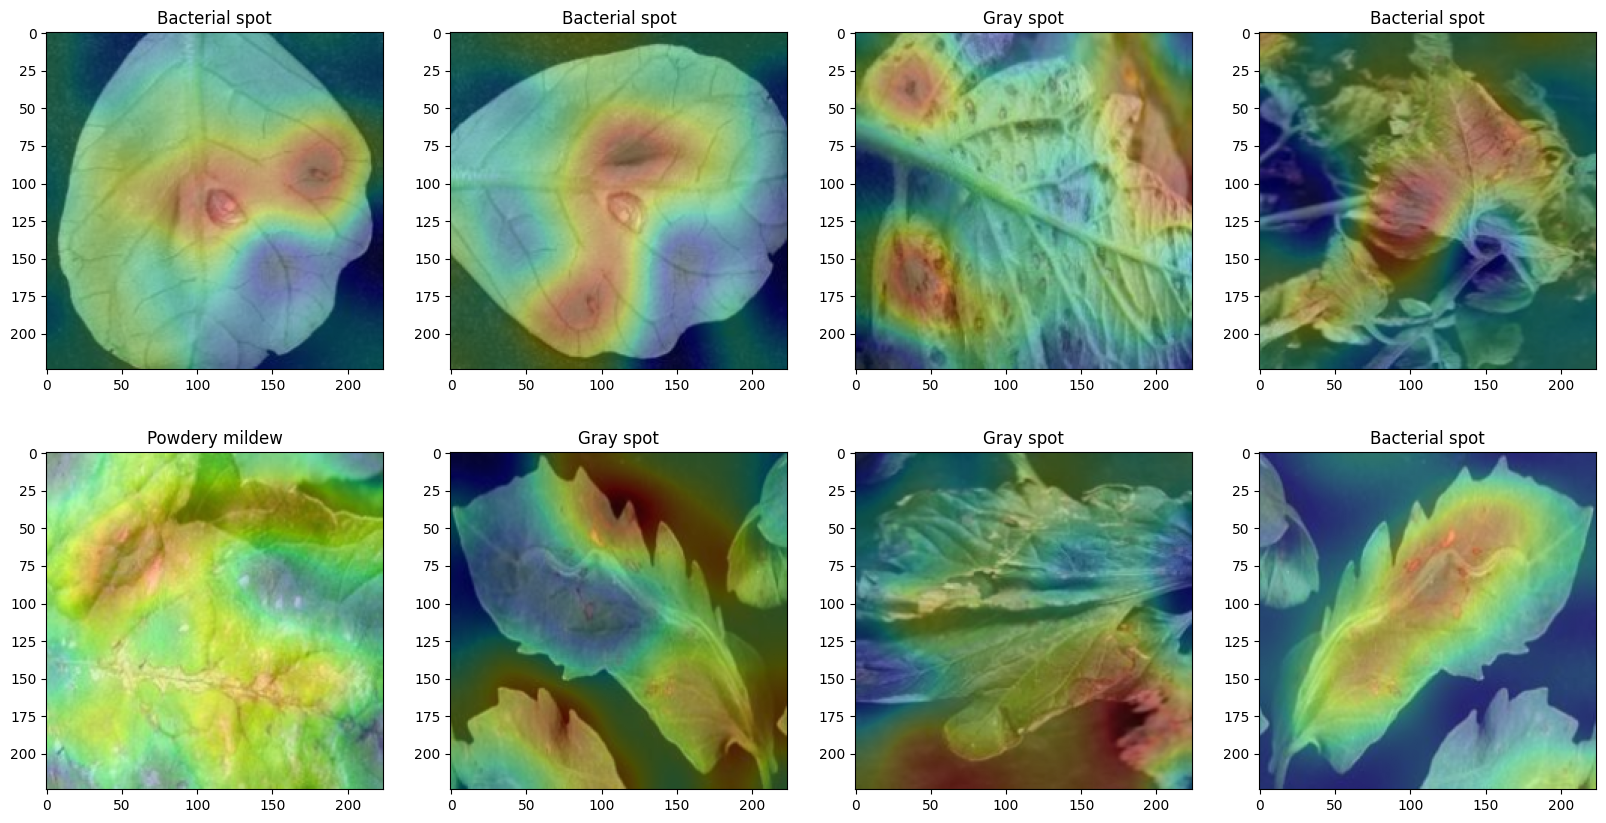

In [ ]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.imshow(i[1], cmap='jet', alpha=0.3)
  plt.title(i[2])
plt.show()  